In [1]:
%matplotlib inline
%gui

# Включение вывода нескольких результатов от одной ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import matplotlib.pyplot as plt
import math
pi = math.pi

plt.rcParams['figure.figsize'] = (15, 4)
print("Модули инициализированы")

Модули инициализированы


In [2]:
def show_vars(*args, **kwargs):
    txt = ""
    for i in range(len(args)):
        v = args[i]
        if type(v)==str: txt+=v;
        if type(v)==list: 
            lst = {};
            for j in range(len(v)): 
                lst[v[j]] = eval(v[j]);
            txt += show_vars(**lst);
        elif type(v)==dict:
            txt += show_vars(**v);
    
    for k in kwargs:
        v = kwargs[k];
        txt += k + '=';
        if type(v) in (int, float):    
            if abs(v)>99.9:   txt += "{:,.0f}".format(v)+"  "
            elif abs(v)>9.99:   txt += "{:,.1f}".format(v)+"  "
            elif abs(v)>0.99:   txt += "{:,.2f}".format(v)+"  "
            elif abs(v)>0.09:   txt += "{:,.3f}".format(v)+"  "
            else:               txt += "{:,.5f}".format(v)+"  "
        else: 
            r = str(type(v)).split("'")
            if len(r)>2: txt += r[1] + "  "
            else: txt += str(type(v))+"  "
    
    return txt
print("Создана функция: show_vars")

Создана функция: show_vars


In [50]:
def save_value(r, name, value, s=None):
    if s:
        if name not in r:      r[name] = {s:value}
        elif s not in r[name]: r[name][s] = value
        else:
            if type(r[name][s])!=list: r[name][s]=[r[name][s]]
            r[name][s].append(value)
    else:
        if name not in r: r[name] = value
        else:
            if type(r[name])!=list: r[name]=[r[name]]
            r[name].append(value)

            
def save_values(r={}, lst=[], s=None, **kwargs):
    for var in lst:
        save_value(r, var, eval(var), s=s)
        
    for k in kwargs:
        save_value(r, k, kwargs[k], s=s)
        
    return r

X = 1 
r = save_values({}, ['X'], Y=X**2, s=1)
X = 2
save_values(r, ['X'], s=1, Y=X**2);
save_values(r, Z=1)

print("Созданы функции: save_value, save_values")

Созданы функции: save_value, save_values


In [107]:
# var_name - название переменной, по которой считаются сценарии
# x_name   - название переменной, по которой разворачивается результат (ось Х)

def acalc(calc_func, var_name, x_name, def_params={}, **kwargs):
    global Uin, Us, L, In, dI, Rint, Usat, Esw, F_min, F_max
    global Irms, dI_est, t_all, D, L, dE, P_loss, Pk_loss, Pl_loss
    
    scope = def_params.copy()
    scope.update(kwargs)
    
    Uin = kwargs.get('Uin',  def_params.get('Uin', 0))
    Us  = kwargs.get('Us',   def_params.get('Us',  0))
    L   = kwargs.get('L',    def_params.get('L',   0))
    In  = kwargs.get('In',   def_params.get('In',  0))
    dI  = kwargs.get('dI',   def_params.get('dI',  0))
    Rint= kwargs.get('Rint', def_params.get('Rint',0))
    Usat= kwargs.get('Usat', def_params.get('Usat',0))
    Esw = kwargs.get('Esw',  def_params.get('Esw', 0))
    F   = kwargs.get('F', 0)
    F_max = kwargs.get('F_max', F if F else kwargs.get('F_max', 20000))
    F_min = kwargs.get('F_min', F if F else kwargs.get('F_min', 1))
    
    def set_value(name, value):
        global  Uin, Us, L, In, dI, Rint, Usat, F_min, F_max
        
        if name == 'Uin' : Uin  = value
        if name == 'Us'  : Us   = value
        if name == 'L'   : L    = value
        if name == 'In'  : In   = value
        if name == 'dI'  : dI   = value
        if name == 'Rint': Rint = value
        if name == 'Usat': Usat = value
        if name == 'F_min': F_min = value
        if name == 'F_max': F_max = value
    
    r = {};

    if x_name in kwargs: ax = kwargs[x_name]
    else:                ax = defs[x_name]

    print("Сценарии:", var_name, "=", kwargs[var_name])
    for s in kwargs[var_name]:
        if var_name=='F': F_min=s;F_max=s;
        else: set_value(var_name, s);
        
        for x in ax:
            set_value(x_name, x);
            calc_func()            
            save_values(r, ['Irms', 'dI_est', 'D', 'K', 'dE', 'P_loss', 'Pk_loss', 'Pl_loss'], F=1/t_all, s=s)
    
    r['s_name'] = var_name    
    r['x_name'] = x_name
    r['s'] = np.array(kwargs[var_name])    
    r['x'] = np.array(ax)
    
    return r    

print("Создана функция: acalc")

Создана функция: acalc


In [71]:
def plot_res(r, values, xname='x', plot_size=0):
    if plot_size==0: plot_size = plot_size = 100 + 10*len(values);
    for i in range(len(values)):
        plt.subplot(plot_size + i + 1);
        plt.grid();
        plt.title(values[i]);
        plt.xlabel(r['x_name']);
        
        if 's' in r:
            for s in r['s']:
                lbl = r['s_name'] + '=' + str(s);
                plt.plot(r[xname], r[values[i]][s], label=lbl);
            plt.legend();
        else:
            plt.plot(r[xname], r[values[i]])
        
print("Создана функция: plot_res")

Создана функция: plot_res


## 1. Расчет преобразователя в режиме заряда

In [110]:
def calc_FD_store():
    global Uin, Us, In, dI, L, Rint, F_min, F_max
    
    t_on  = (L * dI) / (Uin - Us)
    t_off = (L * dI) / (Us + Rint*In)
    dI_est = dI
    
    try:
        k = (t_on + t_off) * F_max   # Проверка: если выбранная частота > F_max
        if k < 1: 
            t_on /= k                # Уменьшаем время включения
            t_off /= k               # Уменьшаем время выключения
            dI_est *= k              # Уменьшаем dI

        k = (t_on + t_off) * F_min   # Проверка: если выбранная частота < F_min
        if k > 1:
            t_on /= k                # Уменьшаем время включения
            t_off /= k               # Уменьшаем время выключения
            dI_est /= k              # Уменьшаем dI
    except:
        raise BaseException(show_vars("calc_FD_store: k="+str(k), ['t_on', 't_off', 'F_max', 'F_min']))

    return t_on, t_off, dI_est


def calc_Irms_store():
    global Uin, Us, L, In, dI, Usat, Esw, Rint
    global t_all, Irms, D, K, P_loss, Pk_loss, Pl_loss
    global dE, dE_loss, dE_est
    Uvd = Usat
    
    t_on, t_off, dI_est = calc_FD_store()

    Imax = In + dI_est / 2   
    Imin = In - dI_est / 2
    
    t_all = t_on + t_off
    D = t_on / t_all
    dE = L * (Imax**2 - Imin**2) / 2 
    
    Pvt_loss = Usat * In * D + Esw / t_all
    dEvt_loss = Pvt_loss * t_all
    
    Pvd_loss = Uvd * In * (1-D)
    dEvd_loss = Pvd_loss * t_all
    
    dEl_loss = Rint * In**2 * t_all 
    
    dE_loss = dEvt_loss + dEvd_loss + dEl_loss
    dE_est  = dE - dE_loss
    Irms    = dE_est / Uin / t_all
    K       = dE_est / dE
    
    Pk_loss = (dEvt_loss+dEvd_loss) / t_all
    Pl_loss = dEl_loss / t_all
    P_loss  = dE_loss / t_all
    
Uin  = 650
Us   = 300
In   = 300
dI   = 400
L    = 100e-6
Rint = 0.02
F_max = 3000
F_min = 3000
t_on, t_off, dI_est = calc_FD_store()

Usat = 2
Esw  = 0.05
calc_Irms_store()
show_vars(['t_on', 't_off', 'dI_est', 'dE', 'dE_loss', 'Irms', 'K'], F=1/(t_on+t_off), D=t_on/(t_on+t_off))

't_on=0.00016  t_off=0.00018  dI_est=294  dE=8.82  dE_loss=0.850  Irms=36.8  K=0.904  F=3,000  D=0.466  '

In [196]:
# Массив значений Us для моделирования
aUs = np.arange(100, 48*10, 5)

# Параметры моделирования по-умолчанию
defs = {
    'Us'   : aUs,      # Напряжение на накопителе (массив значений для оси Х), В 
    'Uin'  : 650,      # Напряжение на нагрузке, В
    'L'    : 100e-6,   # Индуктивность дросселя, Гн
    'In'   : 300,      # Номинальный ток ключа, А
    'dI'   : 300,      # Амплитуда колебаний тока в дросселе, А
    'Rint' : 0.01,     # Внутреннее сопротивление дроселя, Ом
    'Usat' : 2,        # Напряжение на переходе открытого ключа, В
    'Esw'  : 0.05      # Потери на переключение ключа, Дж
}

- Модель вычисляет время включения (t_on) и выключения (t_off) ключа исходя из ограничений по максимальному току в катушке (Imax = In + dI/2), где dI - амлитуда колебания тока в катушке
- Частота переключений $ F = \frac{1}{t_{on} + t_{off}} $

Показатели на графиках:
- Irms - действующее значение тока в точке подключения нагрузки, А
- F - частота работы преобразователя, Гц
- K - коэффициент полезного действия преобразователя
- Pk_loss - мощность тепловых потерь на ключе, Вт
- Us - напряжение на накопителе энергии

### 1.1 Амплитуда пульсаций
- не влияет на выходной ток
- ограничивается характеристиками ключа. При In=300, dI=400 => Imax = 500, что меньше чем 2 * In ключа

Сценарии: dI = [200, 300, 400]


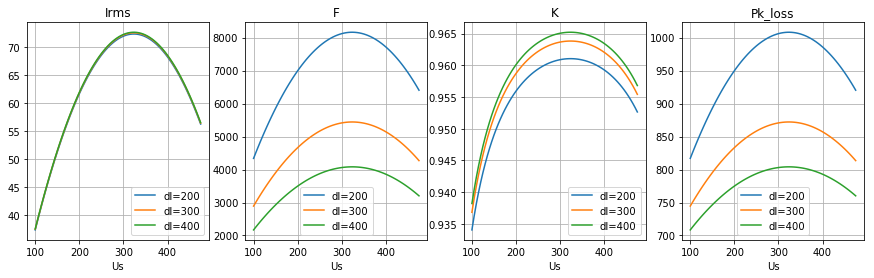

In [197]:
adI = [200, 300, 400]
r = acalc(calc_Irms_store, 'dI', 'Us', defs, dI=adI);
plot_res(r, ['Irms', 'F', 'K', 'Pk_loss'])

### 1.2 Частота преобразования
Предлагается сделать изменяемой в зависимости от расчетного времени изменения тока в индуктвности

Если сделать частоту преобразования фиксированной:
- снизиться действующее значение тока на нагрузке и КПД в зонах где рассчетная частота выше заданной
- возрастут потери ключе в зонах где расчетная частота ниже заданной

Сценарии: F = [2000, 4000, 6000]


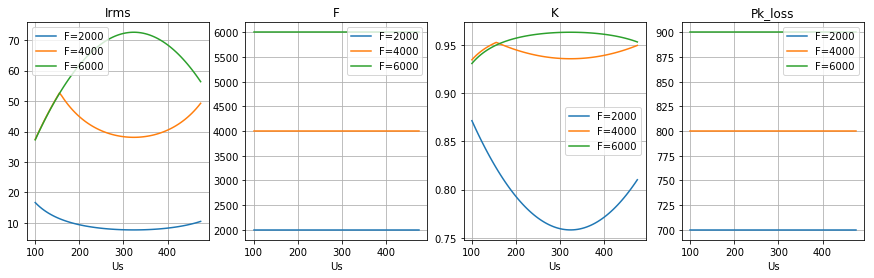

In [113]:
aF = [2000, 4000, 6000]
r = acalc(calc_Irms_store, 'F', 'Us', defs, F=aF);
plot_res(r, ['Irms', 'F', 'K', 'Pk_loss'])

### 1.3 Ток ключей
- Действующее значение тока к нагрузке линейно зависит от номинального напряжения ключа.
- Предлагается использовать 3-4 ключа мощность 300-400А

Сценарии: In = [150, 200, 300, 400]


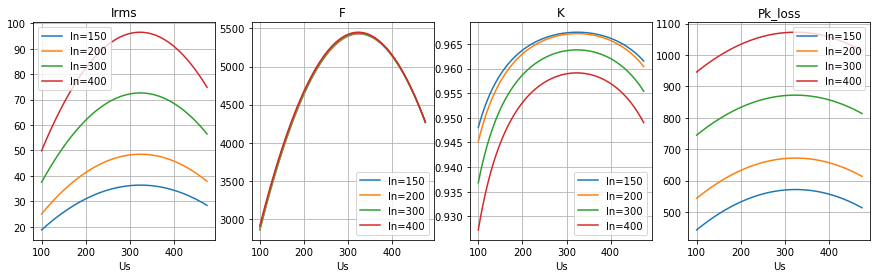

In [114]:
aIn = [150, 200, 300, 400]
r = acalc(calc_Irms_store, 'In', 'Us', defs, In=aIn);
plot_res(r, ['Irms', 'F', 'K', 'Pk_loss'])

### 1.4 Индуктивность
- Индуктивность можно подобрать исходя из максимальной рассеиваемой мощности на ключе (Pk_loss) 

Сценарии: L = [5e-05, 7.5e-05, 0.0001, 0.00015]


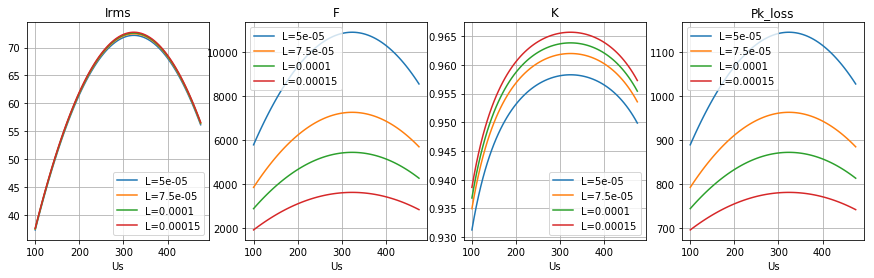

In [115]:
aL = [50e-6, 75e-6, 100e-6, 150e-6]
r = acalc(calc_Irms_store, 'L', 'Us', defs, L=aL);
plot_res(r, ['Irms', 'F', 'K', 'Pk_loss'])

Зависимость максимальных потерь на ключе от индуктивности 
Us= 300
Сценарии: In = [150, 200, 300, 400]


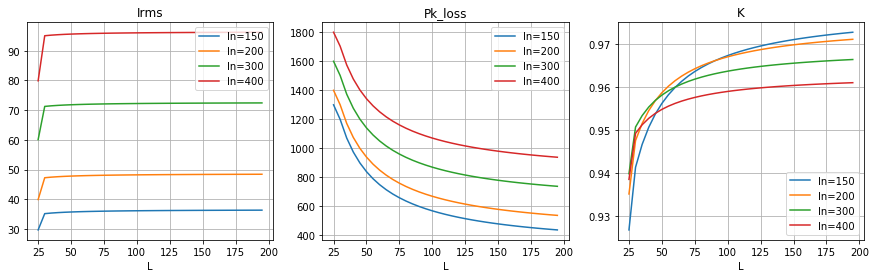

In [116]:
aL = np.arange(25e-6, 200e-6, 5e-6)
aIn = [150, 200, 300, 400]
print("Зависимость максимальных потерь на ключе от индуктивности ")
print('Us=', 300)
r = acalc(calc_Irms_store, 'In', 'L', defs, L=aL, In=aIn, Us=300);
r['x'] *= 1e6
plot_res(r, ['Irms', 'Pk_loss', 'K'])

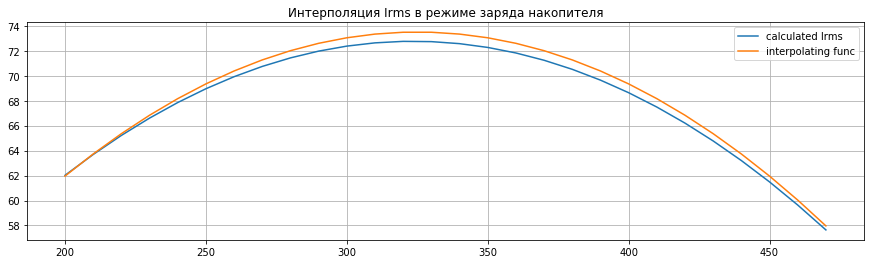

In [179]:
In = 300
dI = 300
Uin = 650
L = 150e-6
Rint = 0.01
Usat = 2

aIrms = []
aF = []
aFunc = []
for Us in aUs:
    calc_Irms_store()
    aIrms.append(Irms)
    aF.append(1/t_all)
    aFunc.append( In*(Uin/2500-0.012-In/100000)-((Us-Uin/2)*(0.65 + 0.33 * In / 300)  )**2/(2*Uin) )
    
plt.plot(aUs, aIrms, label="calculated Irms");
plt.plot(aUs, aFunc, label="interpolating func");
plt.legend();
plt.title("Интерполяция Irms в режиме заряда накопителя");
plt.grid();

Функция интерполяции
$ I_{rms} = I_n * (\frac{U_{in}}{2500} - 0.01) - \frac{(U_s-\frac{U_{in}}2)^2}{2*U_{in}} $

## 2. Расчет цикла разряда накопителя идентичен расчету циклу заряда

Для цикла разряда:
- $ t_{off} = \frac{L * dI}{Uin - Us} $
- $ t_{on}  = \frac{L * dI}{Us - R_{int} * In} $

Для цикла заряда:
- $ t_{on}  = \frac{L * dI}{Uin - Us} $
- $ t_{off} = \frac{L * dI}{Us + R_{int}*In} $


## 3. Тепловые расчеты

In=300  dI=300  Uin=650  


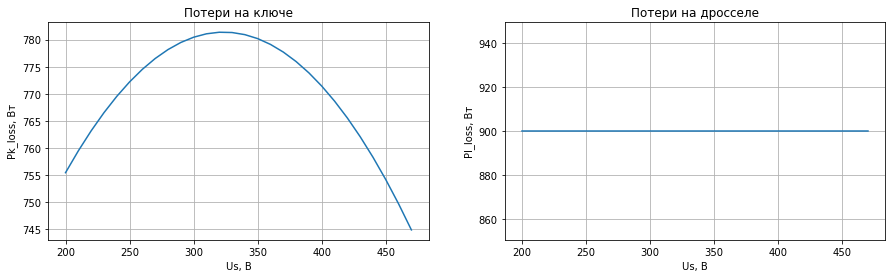

In [183]:
print( show_vars(['In', 'dI', 'Uin']) )

Evt=[]; El=[]
for Us in aUs:
    calc_Irms_store()
    Evt.append(Pk_loss)
    El.append(Pl_loss)
    
plt.subplot(121)
plt.plot(aUs, Evt);
plt.title("Потери на ключе");
plt.xlabel("Us, В");
plt.ylabel("Pk_loss, Вт");
plt.grid();

plt.subplot(122)
plt.plot(aUs, El);
plt.title("Потери на дросселе");
plt.xlabel("Us, В");
plt.ylabel("Pl_loss, Вт");
plt.grid();

### 3.1 Расчет цикла разряда накопителя с максимальной отдаваемой мощностью

In [189]:
Uin = 650
L = 100e-6
In = 400 
dI = 400
Us = 480
Us_min = 150
Cs = 16.5/3
Esw = 0.05
Usat = 2

T = 0; i=0;
r={}; r['T']=[]; r['Us']=[]; r['Pk_loss']=[]; r['dE']=[]; r['dt']=[];r['Irms']=[];r['F']=[];r['D']=[]
while (Us > Us_min) & (i<200000):
    calc_Irms_store()
    i +=1
    T += t_all
    
    Us1 = (Us**2 - dE * 2 / Cs)**0.5
    if type(Us1)==complex: 
        show_vars("Us1 is complex ", ['i', 'Us', 'dE', 'L'])
        break
    if Us1<0: show_vars("Us1<0", ['i', 'Us', 'dE', 'L'])
    Us = Us1
    
    r['dt'].append(t_all)
    r['F'].append(1/t_all)
    r['D'].append(D)
    r['Irms'].append(Irms)
    r['T'].append(T)
    r['Us'].append(Us)
    r['dE'].append(dE)
    r['Pk_loss'].append(Pk_loss)

print("Кол-во циклов:", len(r['T']))
Ek_loss = float(sum(np.array(r['Pk_loss'])*np.array(r['dt'])))
T = sum(r['dt'])
show_vars("Параметры: ", ['Cs', 'L', 'In', 'dI', 'Us_min', 'Usat', 'Esw'])
show_vars("Результаты: ", T=T, Us_last=r['Us'][-1:][0], E=sum(r['dE']), Ek_loss=Ek_loss, Pk_loss=Ek_loss/T )

Кол-во циклов: 35733


'Параметры: Cs=5.50  L=0.00010  In=400  dI=400  Us_min=150  Usat=2.00  Esw=0.05000  '

'Результаты: T=9.58  Us_last=150  E=571,728  Ek_loss=9,450  Pk_loss=987  '

- T - время цикла разряда, сек
- Us_last - напряжение на накопителе в конце цикла, В
- E - энергия переданная в нагрузку, Дж
- Ek_loss - энергия на нагрев ключа, Дж
- Pk_loss - средная мощнотсь нагрева ключа, Вт

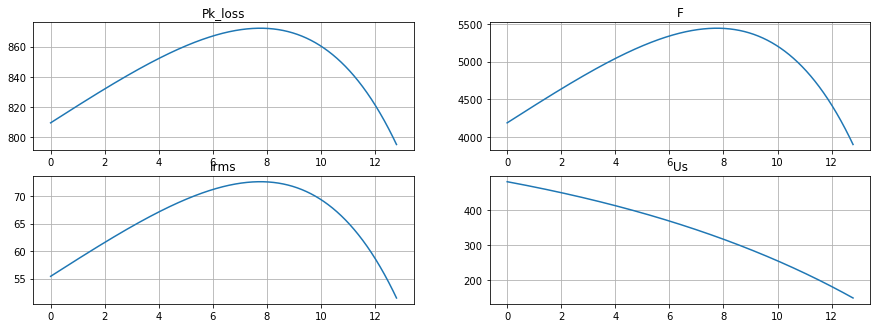

In [141]:
plt.figure(figsize=(15,8))
r['x_name'] = ''
plot_res(r, ['Pk_loss', 'F', 'Irms', 'Us'], plot_size=320, xname='T');

### 3.2 Расчет нагрева радиатора без учета отвода тепла

In [145]:
# Расчет нагрева радиатора, без учета отвода тепла

Pwarm = 1000  # Мощность выделяемая на нагрев, Вт
c_al = 880    # Теплоемкость аллюминия, Дж/кг*К
mr = 0.3      # Масса радиатора, кг
t = 13        # Время нагрева, сек
T1 = Pwarm*t / c_al / mr
print("Расчет нагрева радиатора")
show_vars("Параметры: ", ['Pwarm', 'c_al', 'mr', 't'])
show_vars("Увеличение температуры радиатора: ", ['T1'])

Расчет нагрева радиатора


'Параметры: Pwarm=1,000  c_al=880  mr=0.300  t=13.0  '

'Увеличение температуры радиатора: T1=49.2  '

### 3.3 Расчет дросселя

In [155]:
# Расчет дросселя 130x70x70
Dr_d1 = 0.07
Dr_d2 = 0.13
Dr_h  = 0.07
dw=0.071e-3                          # Диаметр одного проводника
sw=(dw/2)**2*pi                      # Сечение одного проводника
ws = 600*sw                          # Сечение провода, мм2
d = (ws*1e-6*2 / math.pi)**0.5*2     # диаметр провода, м
l = (0.130+0.07)/2 * math.pi         # Длина средней линии магнитопровода
S = (0.130-0.070) * 0.070            # Сечение магнитопровода
u = 20                               # Магнитная проницаемость с учетом зазора (без зазора = 40) 
u0 = 4*math.pi*1e-7                  # Магнитная постоянная
lw = ((0.130-0.070) + 0.070)*2 + d*2 # Длина провода для одного витка
w = 17                               # Кол-во витков
Imax = 450                           # Максимальный ток
Irms = 300                           # Дейст.ток

L = w**2 * u*u0*S/l                  # Ф.3.22
B = L*Imax/w/S                       # Ф.9.46
Rl = 0.017 * lw * w / (0.071 * 600)  # Внутр.сопротивление дросселя
print("Индуктивность, мкГн", L*10**6)
print("Макс.индукция (B), Тл", B)
print("Кол-во витков", w)
print("Длина провода, м", lw*w)
print("Диаметр провода (литцендрат), м", d)
print("Коэф.заполнения", (d/2)**2*math.pi*w / ((Dr_d1/2)**2*math.pi))
print("Плотность тока, А/мм2", Irms/ws/1e6)
print("Внутр.сопротивление, Ом", Rl)
print("Выделение тепла на Rint, Вт", Rl*Irms**2)

Индуктивность, мкГн 97.10400000000001
Макс.индукция (B), Тл 0.612
Кол-во витков 17
Длина провода, м 4.42008362341299
Диаметр провода (литцендрат), м 2.4595121467478057e-06
Коэф.заполнения 2.098702040816326e-08
Плотность тока, А/мм2 126.2883896781554
Внутр.сопротивление, Ом 0.0017638831361037755
Выделение тепла на Rint, Вт 158.7494822493398


## 4. Расчет LC контуров

In [192]:
L = 100e-6 # Индуктивность, Гн
C = 16.5   # Емкость накопителя, Ф
Fr = 1 / (2*pi * (L*C)**0.5 )
print("Резонансная частота накопителя {:.0f} Гц".format(Fr))

L = 100e-6  # Индуктивность, Гн
C = 500e-6  # Емкость фильтра на выходе, Ф
Fr = 1 / (2*pi * (L*C)**0.5 )
print("Резонансная частота на фильтра на выходе {:.0f} Гц".format(Fr))

L = 100e-6  # Индуктивность, Гн
C = 0.005   # Емкость на снаббере, перед нагрузкой, Ф
Fr = 1 / (2*pi * (L*C)**0.5 )
print("Резонансная частота на фильтра перед нагрузкой {:.0f} Гц".format(Fr))


Резонансная частота накопителя 4 Гц
Резонансная частота на фильтра на выходе 712 Гц
Резонансная частота на фильтра перед нагрузкой 225 Гц
